In [1]:
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pandas as pd

torch.set_grad_enabled(False)

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: mps


### Loading a pretrained Sparse Autoencoder

As a first step, we will actually load an SAE! But before we do so, it can be useful to see which are available. The following snippet shows the currently available SAE releases in SAELens, and will remain up-to-date as we continue to add more SAEs.

In [11]:
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

df = pd.DataFrame.from_records({k:v.__dict__ for k,v in get_pretrained_saes_directory().items()}).T
df.drop(columns=["expected_var_explained", "expected_l0", "config_overrides", "conversion_func"], inplace=True)
df # Each row is a "release" which has multiple SAEs which may have different configs / match different hook points in a model. 

release  \
gemma-2b-it-res-jb                                                                 gemma-2b-it-res-jb   
gemma-2b-res-jb                                                                       gemma-2b-res-jb   
gemma-scope-27b-pt-res                                                         gemma-scope-27b-pt-res   
gemma-scope-27b-pt-res-canonical                                     gemma-scope-27b-pt-res-canonical   
gemma-scope-2b-pt-att                                                           gemma-scope-2b-pt-att   
gemma-scope-2b-pt-att-canonical                                       gemma-scope-2b-pt-att-canonical   
gemma-scope-2b-pt-mlp                                                           gemma-scope-2b-pt-mlp   
gemma-scope-2b-pt-mlp-canonical                                       gemma-scope-2b-pt-mlp-canonical   
gemma-scope-2b-pt-res                                                           gemma-scope-2b-pt-res   
gemma-scope-2b-pt-res-canonical                                       gemma-scope-2b-pt-res-canonical   
gemma-scope-9b-it-res                                                           gemma-scope-9b-it-res   
gemma-scope-9b-it-res-canonical                                       gemma-scope-9b-it-res-canonical   
gemma-scope-9b-pt-att                                                           gemma-scope-9b-pt-att   
gemma-scope-9b-pt-att-canonical                                       gemma-scope-9b-pt-att-canonical   
gemma-scope-9b-pt-mlp                                                           gemma-scope-9b-pt-mlp   
gemma-scope-9b-pt-mlp-canonical                                       gemma-scope-9b-pt-mlp-canonical   
gemma-scope-9b-pt-res                                                           gemma-scope-9b-pt-res   
gemma-scope-9b-pt-res-canonical                                       gemma-scope-9b-pt-res-canonical   
gpt2-small-attn-out-v5-128k                                               gpt2-small-attn-out-v5-128k   
gpt2-small-attn-out-v5-32k                                                 gpt2-small-attn-out-v5-32k   
gpt2-small-hook-z-kk                                                             gpt2-small-hook-z-kk   
gpt2-small-mlp-out-v5-128k                                                 gpt2-small-mlp-out-v5-128k   
gpt2-small-mlp-out-v5-32k                                                   gpt2-small-mlp-out-v5-32k   
gpt2-small-mlp-tm                                                                   gpt2-small-mlp-tm   
gpt2-small-res-jb                                                                   gpt2-small-res-jb   
gpt2-small-res-jb-feature-splitting                               gpt2-small-res-jb-feature-splitting   
gpt2-small-res_sce-ajt                                                         gpt2-small-res_sce-ajt   
gpt2-small-res_scefr-ajt                                                     gpt2-small-res_scefr-ajt   
gpt2-small-res_scl-ajt                                                         gpt2-small-res_scl-ajt   
gpt2-small-res_sle-ajt                                                         gpt2-small-res_sle-ajt   
gpt2-small-res_slefr-ajt                                                     gpt2-small-res_slefr-ajt   
gpt2-small-res_sll-ajt                                                         gpt2-small-res_sll-ajt   
gpt2-small-resid-mid-v5-128k                                             gpt2-small-resid-mid-v5-128k   
gpt2-small-resid-mid-v5-32k                                               gpt2-small-resid-mid-v5-32k   
gpt2-small-resid-post-v5-128k                                           gpt2-small-resid-post-v5-128k   
gpt2-small-resid-post-v5-32k                                             gpt2-small-resid-post-v5-32k   
mistral-7b-res-wg                                                                   mistral-7b-res-wg   
pythia-70m-deduped-att-sm                                                   pythia-70m-deduped-att-sm   

In practice, SAEs can be of varying usefulness for general use cases. To start with, we recommend the following:
1. Joseph's Open Source GPT2 Small Residual (gpt2-small-res-jb)
2. Joseph's Feature Splitting (gpt2-small-res-jb-feature-splitting)
3. Gemma SAEs (gemma-2b-res-jb) (0,6) <- on Neuronpedia and good. (12 / 17 aren't very good currently).
4. Other SAEs have various issues--e.g., too dense or not dense enough, or designed for special use cases, or initial drafts of what we hope will be better versions later. Decode Research / Neuronpedia are working on making all SAEs on Neuronpedia loadable in SAE Lens and vice versa, as well as providing public benchmarking stats to help people choose which SAEs to work with.

To see all the SAEs contained in a specific release (named after the part of the model they apply to), simply run the below. Each hook point corresponds to a layer or module of the model.

In [13]:
# show the contents of the saes_map column for a specific row
print("SAEs in the GTP2 Small Resid Pre release")
for k,v in df.loc[df.release == "gpt2-small-res-jb", "saes_map"].values[0].items():
    print(f"SAE id: {k} for hook point: {v}")

print("-"*50)
print("SAEs in the feature splitting release")
for k,v in df.loc[df.release == "gpt2-small-res-jb-feature-splitting", "saes_map"].values[0].items():
    print(f"SAE id: {k} for hook point: {v}")
    
print("-"*50)
print("SAEs in the Gemma base model release")
for k,v in df.loc[df.release == "gemma-2b-res-jb", "saes_map"].values[0].items():
    print(f"SAE id: {k} for hook point: {v}")

SAEs in the GTP2 Small Resid Pre release
SAE id: blocks.0.hook_resid_pre for hook point: blocks.0.hook_resid_pre
SAE id: blocks.1.hook_resid_pre for hook point: blocks.1.hook_resid_pre
SAE id: blocks.2.hook_resid_pre for hook point: blocks.2.hook_resid_pre
SAE id: blocks.3.hook_resid_pre for hook point: blocks.3.hook_resid_pre
SAE id: blocks.4.hook_resid_pre for hook point: blocks.4.hook_resid_pre
SAE id: blocks.5.hook_resid_pre for hook point: blocks.5.hook_resid_pre
SAE id: blocks.6.hook_resid_pre for hook point: blocks.6.hook_resid_pre
SAE id: blocks.7.hook_resid_pre for hook point: blocks.7.hook_resid_pre
SAE id: blocks.8.hook_resid_pre for hook point: blocks.8.hook_resid_pre
SAE id: blocks.9.hook_resid_pre for hook point: blocks.9.hook_resid_pre
SAE id: blocks.10.hook_resid_pre for hook point: blocks.10.hook_resid_pre
SAE id: blocks.11.hook_resid_pre for hook point: blocks.11.hook_resid_pre
SAE id: blocks.11.hook_resid_post for hook point: blocks.11.hook_resid_post
---------------

Next we'll load a specific SAE, as well as a copy of GPT-2 Small to attach it to. To load the model, we'll use the HookedSAETransformer class, which is adapted from the TransformerLens HookedTransformer

In [2]:
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer

model = HookedSAETransformer.from_pretrained("gpt2-small", device = device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience. 
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # <- Release name 
    sae_id = "blocks.7.hook_resid_pre", # <- SAE id (not always a hook point!)
    device = device
)

/Users/shiyang/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shiyang/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


/Users/shiyang/miniconda3/envs/llm/lib/python3.10/site-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


The "sae" object is an instance of the SAE (Sparse Autoencoder class). There are many different SAE architectures which may have different weights or activation functions. In order to simplify working with SAEs, SAE Lens handles most of this complexity for you. 

Let's look at the SAE config and understand each of the parameters:

1. `architecture`: Specifies the type of SAE architecture being used, in this case, the standard architecture (encoder and decoder with hidden activations, as opposed to a gated SAE).
2. `d_in`: Defines the input dimension of the SAE, which is 768 in this configuration.
3. `d_sae`: Sets the dimension of the SAE's hidden layer, which is 24576 here. This represents the number of possible feature activations.
4. `activation_fn_str`: Specifies the activation function used in the SAE, which is ReLU in this case. TopK is another option that we will not cover here.
5. `apply_b_dec_to_input`: Determines whether to apply the decoder bias to the input, set to True here.
6. `finetuning_scaling_factor`: Indicates whether to use a scaling factor to weight initialization and the forward pass. This is not usually used and was introduced to support a [solution for shrinkage](https://www.lesswrong.com/posts/3JuSjTZyMzaSeTxKk/addressing-feature-suppression-in-saes).
7. `context_size`: Defines the size of the context window, which is 128 tokens in this case. In turns out SAEs trained on small activations from small prompts [often don't perform well on longer prompts](https://www.lesswrong.com/posts/baJyjpktzmcmRfosq/stitching-saes-of-different-sizes).
8. `model_name`: Specifies the name of the model being used, which is 'gpt2-small' here. [This is a valid model name in TransformerLens](https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html).
9. `hook_name`: Indicates the specific hook in the model where the SAE is applied.
10. `hook_layer`: Specifies the layer number where the hook is applied, which is layer 7 in this case.
11. `hook_head_index`: Defines which attention head to hook into; not relevant here since we are looking at a residual stream SAE.
12. `prepend_bos`: Determines whether to prepend the beginning-of-sequence token, set to True.
13. `dataset_path`: Specifies the path to the dataset used for training or evaluation. (Can be local or a huggingface dataset.)
14. `dataset_trust_remote_code`: Indicates whether to trust remote code (from HuggingFace) when loading the dataset, set to True.
15. `normalize_activations`: Specifies how to normalize activations, set to 'none' in this config.
16. `dtype`: Defines the data type for tensor operations, set to 32-bit floating point.
17. `device`: Specifies the computational device to use.
18. `sae_lens_training_version`: Indicates the version of SAE Lens used for training, set to None here.
19. `activation_fn_kwargs`: Allows for additional keyword arguments for the activation function. This would be used if e.g. the `activation_fn_str` was set to `topk`, so that `k` could be specified.

In [15]:
print(sae.cfg.__dict__)

{'architecture': 'standard', 'd_in': 768, 'd_sae': 24576, 'activation_fn_str': 'relu', 'apply_b_dec_to_input': True, 'finetuning_scaling_factor': False, 'context_size': 128, 'model_name': 'gpt2-small', 'hook_name': 'blocks.7.hook_resid_pre', 'hook_layer': 7, 'hook_head_index': None, 'prepend_bos': True, 'dataset_path': 'Skylion007/openwebtext', 'dataset_trust_remote_code': True, 'normalize_activations': 'none', 'dtype': 'torch.float32', 'device': 'mps', 'sae_lens_training_version': None, 'activation_fn_kwargs': {}, 'neuronpedia_id': 'gpt2-small/7-res-jb', 'model_from_pretrained_kwargs': {'center_writing_weights': True}}


Next we need to load in a dataset to work with. We'll just use a sample of the Pile.

In [16]:
from datasets import load_dataset  
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path = "NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)





Generating train split: 100%|███| 10000/10000 [00:00<00:00, 45185.90 examples/s]

Map:   0%|                                     | 0/10000 [00:00<?, ? examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (229134 > 1024). Running this sequence through the model will result in indexing errors

Map: 100%|████████████████████████| 10000/10000 [00:48<00:00, 205.57 examples/s]


### Basics: What are SAE Features?

#### Opening a feature dashboard on Neuronpedia

Before we dive too deep into the various things you can do with SAEs, let's address a basic question: What is an SAE feature?

An SAE feature represents a pattern or concept that the autoencoder has learned to detect in the input data. These features often correspond to meaningful semantic, syntactic, or otherwise interpretable elements of text, and correspond to linear directions in activation space. SAEs are trained on the activations of a specific part of the model, and after training, these features show up as activations in the hidden layer of the SAE (which is much wider than the source activation vector, and produces one hidden activation per feature). As such, the hidden activations represent a decomposition of the entangled/superimposed features found in the original model activations. Ideally, these activations are sparse: Only a few of the many possible hidden activations actually activate for a given piece of input. This sparseness tends to correspond to ease of interpretability.

The dashboard shown here provides a detailed view of a single SAE feature. (Refresh the cell to see more examples). Let's break down its components:

1. Feature Description: At the top, we see an auto-interp-sourced description of the feature. 

2. Logit Plots: The top positive and negative logits for the feature. The values indicate the strength of the association.

3. Activations Density Plot: This histogram shows the distribution of activation values for this feature across a randomly sampled dataset. The x-axis represents activation strength, and the y-axis shows frequency. The top chart is simply the distribution of non-zero activations, and the second plot shows the density of negative and positive logits.

4. Test Activation: You can use this feature within the notebook or Neuronpedia itself--simply enter text to see how the feature is activated across the text.

5. Top Activations: Below the plots, we see max-activating examples of text snippets that strongly activate this feature. Each snippet is highlighted where the activation appears.

See this section of [Towards Monosemanticity](https://transformer-circuits.pub/2023/monosemantic-features#setup-interface) for more information.

In [8]:
from IPython.display import IFrame

# get a random feature from the SAE
feature_idx = torch.randint(0, sae.cfg.d_sae, (1,)).item()

html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=feature_idx)
IFrame(html, width=1200, height=600)

For the randomly selected feature above, can you predict which text will make it fire? Can you test your theory?

Eg: Imagine it seemed to fire on pokemon. Testing whether the feature fires on Digimon (a similar game with pet monsters) may suggest a different story.

#### Downloading/Searching Autointerp

What if we wanted to search for a feature relating to a specific thing? Then we could use the explanation search API. Let's just download all the [autointerp explanations](https://openai.com/index/language-models-can-explain-neurons-in-language-models/) for these SAE features and load them in as a Pandas dataframe. The Neuronpedia API docs will be useful here: https://www.neuronpedia.org/api-doc#tag/explanations/GET/api/explanation/export.

*Note: not every SAE in SAE Lens is on Neuronpedia and not all SAEs on Neuronpedia have autointerp for all features. This is a work in progress*.

In [18]:
import requests

url = "https://www.neuronpedia.org/api/explanation/export?modelId=gpt2-small&saeId=7-res-jb"
headers = {"Content-Type": "application/json"}

response = requests.get(url, headers=headers)

In [19]:
# convert to pandas
data = response.json()
explanations_df = pd.DataFrame(data)
# rename index to "feature"
explanations_df.rename(columns={"index": "feature"}, inplace=True)
# explanations_df["feature"] = explanations_df["feature"].astype(int)
explanations_df["description"] = explanations_df["description"].apply(lambda x: x.lower())
explanations_df

modelId     layer feature  \
0      gpt2-small  7-res-jb     218   
1      gpt2-small  7-res-jb     218   
2      gpt2-small  7-res-jb     218   
3      gpt2-small  7-res-jb    2020   
4      gpt2-small  7-res-jb    3493   
...           ...       ...     ...   
24568  gpt2-small  7-res-jb   24571   
24569  gpt2-small  7-res-jb   24572   
24570  gpt2-small  7-res-jb   24573   
24571  gpt2-small  7-res-jb   24574   
24572  gpt2-small  7-res-jb   24575   

                                             description explanationModelName  \
0              stars and dashed for censoring expletives                 None   
1              stars and dashes for censoring expletives                 None   
2                      offensive language and expletives                 None   
3                                        names of people        gpt-3.5-turbo   
4                                   references to nazism        gpt-3.5-turbo   
...                                                  ...                  ...   
24568  locations and cities paired with information s...        gpt-3.5-turbo   
24569  actions related to personal grooming, such as ...        gpt-3.5-turbo   
24570                 words containing the sequence "lo"        gpt-3.5-turbo   
24571                instances of added or inserted text        gpt-3.5-turbo   
24572  positive aspects or characteristics of a creat...        gpt-3.5-turbo   

                 typeName  
0      oai_token-act-pair  
1      oai_token-act-pair  
2      oai_token-act-pair  
3      oai_token-act-pair  
4      oai_token-act-pair  
...                   ...  
24568  oai_token-act-pair  
24569  oai_token-act-pair  
24570  oai_token-act-pair  
24571  oai_token-act-pair  
24572  oai_token-act-pair  

[24573 rows x 6 columns]

In [20]:
bible_features = explanations_df.loc[explanations_df.description.str.contains(" bible")]
bible_features

modelId     layer feature  \
11902  gpt2-small  7-res-jb   11735   

                                             description explanationModelName  \
11902  references to religious texts, particularly th...        gpt-3.5-turbo   

                 typeName  
11902  oai_token-act-pair

In [21]:
# Let's get the dashboard for this feature.
html = get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=bible_features.feature.values[0])
IFrame(html, width=1200, height=600)

### Basics: Getting Features Using SAEs

Autointerp is such a bad way to find features. We really care about understanding model predictions on real prompts using SAEs. Let's check for features used in completing this bible verse. Will we see a bible feature?

In [4]:
from transformer_lens.utils import test_prompt

prompt = "In the beginning, God created the heavens and the"
answer = "earth"

# Show that the model can confidently predict the next token.
test_prompt(prompt, answer, model)

Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' heavens', ' and', ' the']
Tokenized answer: [' earth']


Performance on answer token:
Rank: 0        Logit: 27.64 Prob: 99.32% Token: | earth|

Top 0th token. Logit: 27.64 Prob: 99.32% Token: | earth|
Top 1th token. Logit: 22.46 Prob:  0.56% Token: | Earth|
Top 2th token. Logit: 19.20 Prob:  0.02% Token: | planets|
Top 3th token. Logit: 18.80 Prob:  0.01% Token: | moon|
Top 4th token. Logit: 18.07 Prob:  0.01% Token: | heavens|
Top 5th token. Logit: 17.67 Prob:  0.00% Token: | oceans|
Top 6th token. Logit: 17.43 Prob:  0.00% Token: | ten|
Top 7th token. Logit: 17.41 Prob:  0.00% Token: | stars|
Top 8th token. Logit: 17.38 Prob:  0.00% Token: | seas|
Top 9th token. Logit: 17.35 Prob:  0.00% Token: | four|


Ranks of the answer tokens: [(' earth', 0)]

#### Using a HookedSAETransformer

We have a whole tutorial on running models with SAEs using the HookedSAE Transformer class -> <a target="_blank" href="https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Hooked_SAE_Transformer_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Here we'll just demonstrate how to get features using the class.

In [5]:
# SAEs don't reconstruct activation perfectly, so if you attach an SAE and want the model to stay performant, you need to use the error term.
# This is because the SAE will be used to modify the forward pass, and if it doesn't reconstruct the activations well, the outputs may be effected.
# Good SAEs have small error terms but it's something to be mindful of.

sae.use_error_term # If use error term is set to false, we will modify the forward pass by using the sae.

False

Below, we'll use the `run_with_cache_with_saes` function of the HookedSAETransformer, which will give us all the cached activations (including those from the SAE that we've specified in the arguments). Running our prompt through the model gets us activation tensors as follows:

In [6]:
# hooked SAE Transformer will enable us to get the feature activations from the SAE
_, cache = model.run_with_cache_with_saes(prompt, saes=[sae])

print([(k, v.shape) for k,v in cache.items() if "sae" in k])

# note there were 11 tokens in our prompt, the residual stream dimension is 768, and the number of SAE features is 768

[('blocks.7.hook_resid_pre.hook_sae_input', torch.Size([1, 11, 768])), ('blocks.7.hook_resid_pre.hook_sae_acts_pre', torch.Size([1, 11, 24576])), ('blocks.7.hook_resid_pre.hook_sae_acts_post', torch.Size([1, 11, 24576])), ('blocks.7.hook_resid_pre.hook_sae_recons', torch.Size([1, 11, 768])), ('blocks.7.hook_resid_pre.hook_sae_output', torch.Size([1, 11, 768]))]


Next, we'll visualize the activations of the hidden layer of the SAE at the final token position of the prompt. Each of these vertical lines correspond to a feature activation. We can also plot the dashboards for each of these activated features, using their position in the activation cache as an index to pull data from Neuronpedia. We'll do this for the top features only.

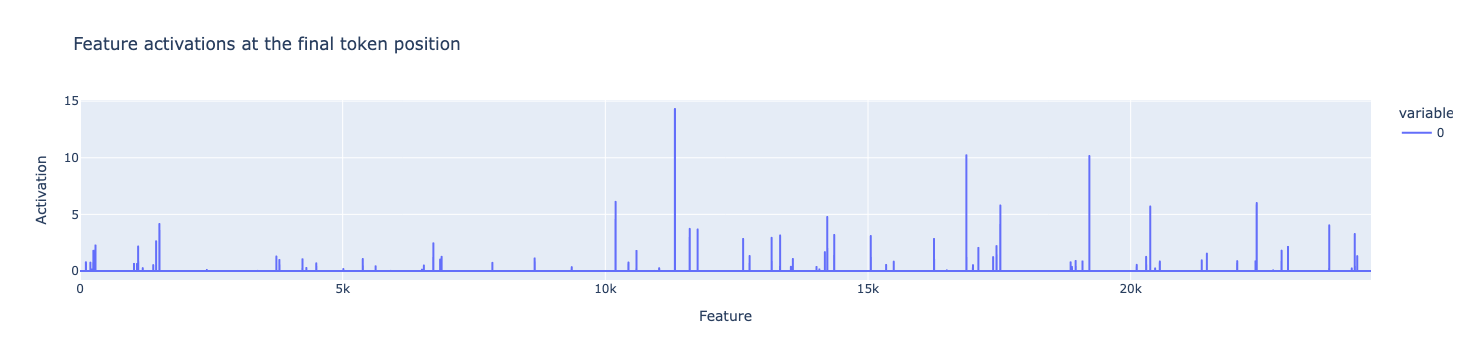

Feature 11325 fired 14.30


Feature 16873 fired 10.23


Feature 19214 fired 10.15


Feature 10195 fired 6.11


Feature 22399 fired 6.00


In [9]:
# let's look at which features fired at layer 8 at the final token position

# hover over lines to see the Feature ID.
px.line(
    cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu().numpy(),
    title="Feature activations at the final token position",
    labels={"index": "Feature", "value": "Activation"},
).show()

# let's print the top 5 features and how much they fired
vals, inds = torch.topk(cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :], 5)
for val, ind in zip(vals, inds):
    print(f"Feature {ind} fired {val:.2f}")
    html = get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=ind)
    display(IFrame(html, width=1200, height=300))

Sometimes we may be interested in which features fire differently between two prompts. Let's investigate this question by comparing the resultant activations. As we can see, using the prompt below changes the logit prediction considerably:

In [10]:
from transformer_lens.utils import test_prompt

prompt = "In the beginning, God created the cat and the"
answer = "earth"

# here we see that removing the word "Heavens" is very effective at making the model no longer predict "earth".
# instead the model predicts a bunch of different animals.
# Can we work out which features fire differently which might explain this? (This is a toy example not meant to be super interesting)
test_prompt(prompt, answer, model)

Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' cat', ' and', ' the']
Tokenized answer: [' earth']


Performance on answer token:
Rank: 34       Logit: 13.42 Prob:  0.30% Token: | earth|

Top 0th token. Logit: 18.10 Prob: 32.26% Token: | dog|
Top 1th token. Logit: 17.59 Prob: 19.38% Token: | mouse|
Top 2th token. Logit: 16.10 Prob:  4.37% Token: | lamb|
Top 3th token. Logit: 15.72 Prob:  2.98% Token: | woman|
Top 4th token. Logit: 15.34 Prob:  2.03% Token: | bear|
Top 5th token. Logit: 15.22 Prob:  1.80% Token: | rabbit|
Top 6th token. Logit: 15.11 Prob:  1.63% Token: | bird|
Top 7th token. Logit: 15.03 Prob:  1.50% Token: | goat|
Top 8th token. Logit: 14.97 Prob:  1.41% Token: | fox|
Top 9th token. Logit: 14.81 Prob:  1.20% Token: | beast|


Ranks of the answer tokens: [(' earth', 34)]

[('blocks.7.hook_resid_pre.hook_sae_input', torch.Size([2, 11, 768])), ('blocks.7.hook_resid_pre.hook_sae_acts_pre', torch.Size([2, 11, 24576])), ('blocks.7.hook_resid_pre.hook_sae_acts_post', torch.Size([2, 11, 24576])), ('blocks.7.hook_resid_pre.hook_sae_recons', torch.Size([2, 11, 768])), ('blocks.7.hook_resid_pre.hook_sae_output', torch.Size([2, 11, 768]))]


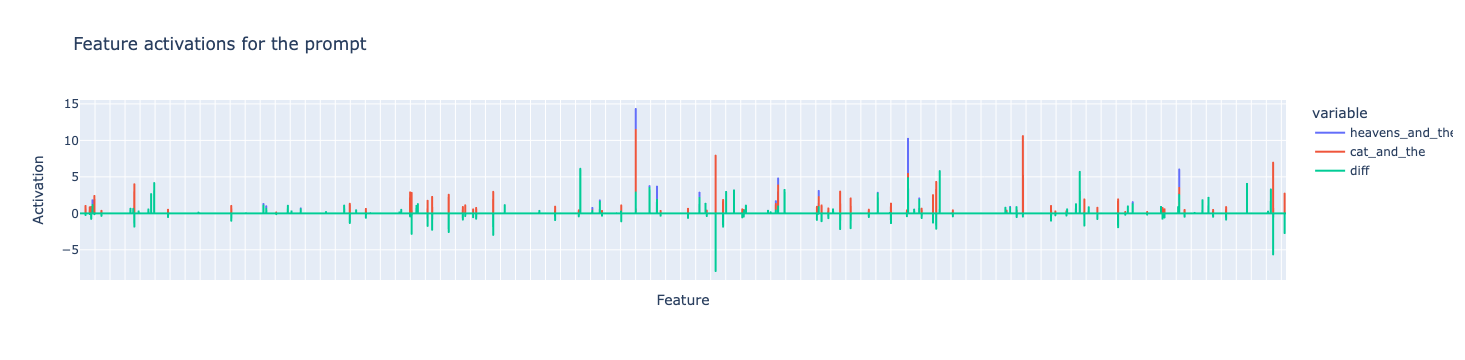

In [11]:
prompt = ["In the beginning, God created the heavens and the", "In the beginning, God created the cat and the"]
_, cache = model.run_with_cache_with_saes(prompt, saes=[sae])
print([(k, v.shape) for k,v in cache.items() if "sae" in k])

feature_activation_df = pd.DataFrame(cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu().numpy(),
                                     index = [f"feature_{i}" for i in range(sae.cfg.d_sae)],
)
feature_activation_df.columns = ["heavens_and_the"]
feature_activation_df["cat_and_the"] = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][1, -1, :].cpu().numpy()
feature_activation_df["diff"]= feature_activation_df["heavens_and_the"] - feature_activation_df["cat_and_the"]

fig = px.line(
    feature_activation_df,
    title="Feature activations for the prompt",
    labels={"index": "Feature", "value": "Activation"},
)

# hide the x-ticks
fig.update_xaxes(showticklabels=False)
fig.show()

We can see that there are differences, but let's plot the feature dashboards for the features with the biggest diffs to see what they are. We can see that the biggest difference is that there is now an active "animal" feature.

In [12]:
# let's look at the biggest features in terms of absolute difference

diff = cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][1, -1, :].cpu() - cache['blocks.7.hook_resid_pre.hook_sae_acts_post'][0, -1, :].cpu()
vals, inds = torch.topk(torch.abs(diff), 5)
for val, ind in zip(vals, inds):
    print(f"Feature {ind} had a difference of {val:.2f}")
    html = get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=ind)
    display(IFrame(html, width=1200, height=300))

Feature 12952 had a difference of 7.91


Feature 10195 had a difference of 6.11


Feature 17519 had a difference of 5.78


Feature 20373 had a difference of 5.69


Feature 24313 had a difference of 5.63


So we see that with cats, there is now an animal predicting feature that fires quite strongly, and a feature that fires on "and" and promotes "valleys" and other geological terms no longer fires. 

### Making Feature Dashboards (Optional)

For those interested, we provide a section showing how to generate the components of feature dashboards. 

We've covered what the feature dashboards are displaying, but let's dive into this in more detail so that we fully understand what the plots signify. To repeat the explanation above and provide more detail, basic feature dashboards have 4 main components:
1. Feature Activation Distribution. We report the proportion of tokens a feature fires on, usually between 1 in every 100 and 1 in every 10,000 tokens activations, and show the distribution of positive activations.  
2. Logit weight distribution. This is the projection of the decoder weight onto the unembed and roughly gives us a sense of the tokens promoted by a feature. It's less useful in big models / middle layers.
3. The top 10 and bottom 10 tokens in the logit weight distribution (positive/negative logits). 
4. **Max Activating Examples**. These are examples of text where the feature fires and usually provide the most information for helping us work out what a feature means. 

**Bonus Section: Reproducing circular subspace geometry from [Not all Language Model Features are Linear](https://arxiv.org/abs/2405.14860)**

*Neuronpedia* is a website that hosts feature dashboards and which runs servers that can run the model and check feature activations. This makes it very convenient to check that a feature fires on the distribution of text you actually think it should fire on. We've been downloading data from Neuronpedia for some of the plots above.

#### Local: Finding Max Activating Examples

We'll start by finding the max-activating examples--the prompts that show the highest level of activation from a feature. First, we'll prepare a feature store, which streams a sample of text from an SAE's orginal training dataset and creates activations for them.

In [13]:
# instantiate an object to hold activations from a dataset
from sae_lens import ActivationsStore

# a convenient way to instantiate an activation store is to use the from_sae method
activation_store = ActivationsStore.from_sae(
    model=model,
    sae=sae,
    streaming=True,
    # fairly conservative parameters here so can use same for larger
    # models without running out of memory.
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=32,
    device=device,
)


To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

# A very handy function Neel wrote to get context around a feature activation
def make_token_df(tokens, len_prefix=5, len_suffix=3, model = model):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    unique_token = [[f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens]
    
    context = []
    prompt = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p==tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        unique_token=list_flatten(unique_token),
        context=context,
        prompt=prompt,
        pos=pos,
        label=label,
    ))

Now we'll generate examples for a random set of features.

The following code does the following (for a randomly selected set of 100 features):
1. Samples tokens from the dataset, prepending a bos if the SAE was trained with that and making sure prompts are the correct size for the SAE.
2. Generates activations, tracking which tokens a feature fired on.
3. (Just for `Not all language model features are linear`) Keeps track of the subspace geneated by those features. 
4. Make a dataframe with all the tokens in all the prompts where at least one feature fired.

*Note: this code is fairly slow in part due to the dataframe concat and in part because we actually have to run the model rather than using cached activations. SAE Lens officially recommends [SAE Dashboard](https://github.com/jbloomAus/SAEDashboard) for dashboard generation in practice. 

In [15]:
# finding max activating examples is a bit harder. To do this we need to calculate feature activations for a large number of tokens
feature_list = torch.randint(0, sae.cfg.d_sae, (100,))
examples_found = 0
all_fired_tokens = []
all_feature_acts = []
all_reconstructions = []
all_token_dfs = []

total_batches = 100
batch_size_prompts = activation_store.store_batch_size_prompts
batch_size_tokens = activation_store.context_size * batch_size_prompts
pbar = tqdm(range(total_batches))
for i in pbar:
    tokens = activation_store.get_batch_tokens()
    tokens_df = make_token_df(tokens)
    tokens_df["batch"] = i
    
    flat_tokens = tokens.flatten()
    
    _, cache = model.run_with_cache(tokens, stop_at_layer = sae.cfg.hook_layer + 1, names_filter = [sae.cfg.hook_name])
    sae_in = cache[sae.cfg.hook_name]
    feature_acts = sae.encode(sae_in).squeeze()

    feature_acts = feature_acts.flatten(0,1)
    fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
    fired_tokens = model.to_str_tokens(flat_tokens[fired_mask])
    reconstruction = feature_acts[fired_mask][:, feature_list] @ sae.W_dec[feature_list]

    token_df = tokens_df.iloc[fired_mask.cpu().nonzero().flatten().numpy()]
    all_token_dfs.append(token_df)
    all_feature_acts.append(feature_acts[fired_mask][:, feature_list])
    all_fired_tokens.append(fired_tokens)
    all_reconstructions.append(reconstruction)
    
    examples_found += len(fired_tokens)
    # print(f"Examples found: {examples_found}")
    # update description
    pbar.set_description(f"Examples found: {examples_found}")
    
# flatten the list of lists
all_token_dfs = pd.concat(all_token_dfs)
all_fired_tokens = list_flatten(all_fired_tokens)
all_reconstructions = torch.cat(all_reconstructions)
all_feature_acts = torch.cat(all_feature_acts)

Examples found: 20748: 100%|██████████████████| 100/100 [01:06<00:00,  1.51it/s]


#### Getting Feature Activation Histogram

Next, we can generate the feature activation histogram (just as we saw on the dashboards above) and display the list of max-activating examples we just generated. We'll just do this for the first feature in our random set (index 0).

In [16]:
feature_acts_df = pd.DataFrame(all_feature_acts.detach().cpu().numpy(), columns = [f"feature_{i}" for i in feature_list])
feature_acts_df.shape

(20748, 100)

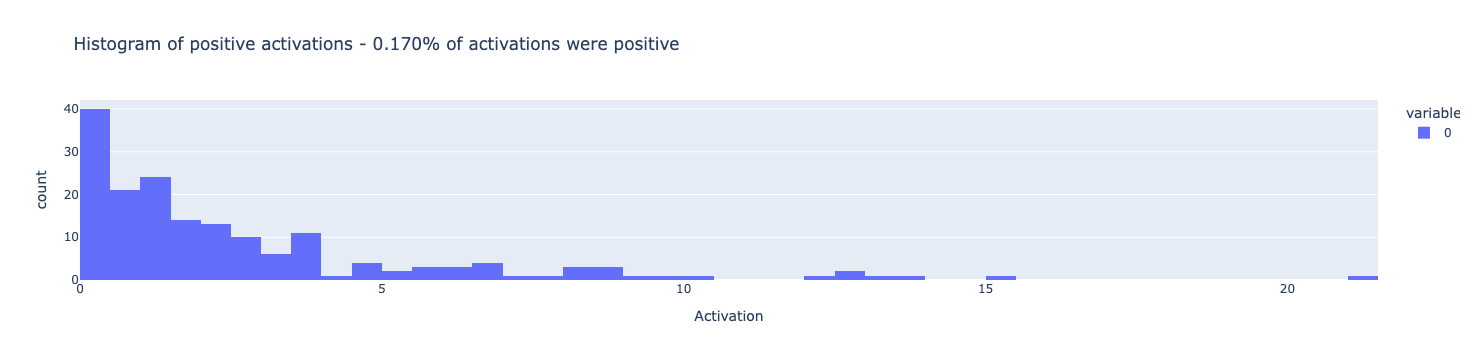

In [17]:
feature_idx = 0
# get non-zero activations

all_positive_acts = all_feature_acts[all_feature_acts[:, feature_idx] > 0][:, feature_idx].detach()
prop_positive_activations = 100*len(all_positive_acts) / (total_batches*batch_size_tokens)

px.histogram(
    all_positive_acts.cpu(),
    nbins=50,
    title=f"Histogram of positive activations - {prop_positive_activations:.3f}% of activations were positive",
    labels={"value": "Activation"},
    width=800,)

In [18]:
top_10_activations = feature_acts_df.sort_values(f"feature_{feature_list[0]}", ascending=False).head(10)
all_token_dfs.iloc[top_10_activations.index] # TODO: double check this is working correctly

str_tokens unique_token  \
826        the       the/58   
189        the       the/61   
567        the       the/55   
705        the       the/65   
288        the       the/32   
459        the       the/75   
781        the       the/13   
269        the       the/13   
268        the       the/12   
41         the       the/41   

                                               context  prompt  pos label  \
826   understandably mention both strands of| the| ...       6   58  6/58   
189     restaurant in big chunks of| the| country, but       1   61  1/61   
567          hated in large parts of| the| Arab world,       4   55  4/55   
705   specific aim at elements of| the| pending tra...       5   65  5/65   
288                �s another part of| the| joke — and       2   32  2/32   
459      over a core part of| the| Affordable Care Act       3   75  3/75   
781      that the west wing of| the| Carlton Hotel has       6   13  6/13   
269      fans of both iterations of| the| character. (       2   13  2/13   
268   that the back half of| the| nominating calend...       2   12  2/12   
41          II, Section 4 of| the| Constitution of the       0   41  0/41   

     batch  
826     36  
189      4  
567     64  
705      2  
288     54  
459     90  
781     20  
269     35  
268      3  
41      13

#### Getting the Top 10 Logit Weights

As a final step, we'll generate the top 10 logit weights--that is, we'll see what tokens each of the features in our set is promoting most strongly.

Note it's important to fold layer norm (by default SAE Lens loads Transformers with folder layer norm but sometimes we turn preprocessing off to save GPU ram and this would affect the logit weight histograms a little bit).

In [19]:
print(f"Shape of the decoder weights {sae.W_dec.shape})")
print(f"Shape of the model unembed {model.W_U.shape}")
projection_matrix = sae.W_dec @ model.W_U
print(f"Shape of the projection matrix {projection_matrix.shape}")

# then we take the top_k tokens per feature and decode them
top_k = 10
# let's do this for 100 random features
_, top_k_tokens = torch.topk(projection_matrix[feature_list], top_k, dim=1)

feature_df = pd.DataFrame(top_k_tokens.cpu().numpy(), index = [f"feature_{i}" for i in feature_list]).T
feature_df.index = [f"token_{i}" for i in range(top_k)]
feature_df.applymap(lambda x: model.tokenizer.decode(x))

Shape of the decoder weights torch.Size([24576, 768]))
Shape of the model unembed torch.Size([768, 50257])
Shape of the projection matrix torch.Size([24576, 50257])


/var/folders/mf/1m_q0cyd0dqdgbbdds_6535m0000gn/T/ipykernel_16665/4260783916.py:14: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



feature_6516   feature_3600 feature_11059    feature_9779  \
token_0     equation    Directorate       Hundred         Consent   
token_1     spectrum        fecture       hundred           goods   
token_2        globe        onomous          esan   manufacturing   
token_3    continuum        Municip   dimensional    manufactures   
token_4    workforce              ğ          hots           Craft   
token_5         city   Organisation         sided      industries   
token_6      country           Yuan         alian            eers   
token_7         same          ariat      thousand     fabrication   
token_8     universe          Tamil        handed         exports   
token_9     populace       Ministry       uscript           Goods   

        feature_6908 feature_650     feature_1685 feature_17550 feature_19999  \
token_0        alike    entirety        officials           bie          aged   
token_1      thereof   remainder       ministries          bing         agers   
token_2         pace      entire           decree          bies         uates   
token_3        sides       globe         shutdown            bi           age   
token_4      concede     process         agencies          bers          ager   
token_5         cale      region      bureaucracy         Dylan          bang   
token_6         peak    vicinity   administration          bles         ishly   
token_7         side   periphery        ministers          cats           ety   
token_8   combatants     country             wide          bish           ish   
token_9      terness      ordeal           overth          bled          Nick   

        feature_9459  ...      feature_10992 feature_15620 feature_14038  \
token_0    orporated  ...         bankruptcy       Orioles    Kaepernick   
token_1          Ltd  ...              brink        Ravens        Powell   
token_2           .,  ...           collapse          Wire     Greenwood   
token_3          orp  ...             uclear          City          otte   
token_4       enture  ...                its         Colts          ulty   
token_5   subsidiary  ...             parity        County          ette   
token_6         iner  ...                  �       Heights          ifer   
token_7         iffe  ...                 ��        Harbor    ottesville   
token_8        ombat  ...  inventoryQuantity         Yards         Moran   
token_9           ./  ...             livion       Hopkins          Reed   

        feature_22016     feature_4  feature_17870     feature_700  \
token_0         TOTAL            's        Notably         Picture   
token_1        Lastly            +.    Accordingly            OPLE   
token_2       Finally       herself          Hence              ��   
token_3         ibaba       himself      Therefore            Cele   
token_4          Ibid   Productions         tumblr         Playboy   
token_5         Total        itself   Additionally             DAQ   
token_6         Total         ruary        However             ARA   
token_7           %);          Tube       Moreover  DragonMagazine   
token_8    Difference           AFB    Furthermore     Occupations   
token_9    Conclusion           tsy           Thus           ivals   

         feature_605 feature_3948 feature_8560  
token_0      oneself       enance      estinal  
token_1   yourselves          ess        spans  
token_2        amera        esses         span  
token_3        illac         ries        holes  
token_4   themselves        eenth         flow  
token_5        senal         reys       seeker  
token_6        blame          ies         hole  
token_7      herself          rey      seekers  
token_8     Yourself          ing        orial  
token_9     yourself         iful        stadt  

[10 rows x 100 columns]

#### Putting it all together: Compare against the Neuronpedia Dashboard

How does this compare to the dashboard data pulled from Neuronpedia? Let's take a look:

In [20]:
html = get_dashboard_html(sae_release = "gpt2-small", sae_id=f"{sae.cfg.hook_layer}-res-jb", feature_idx=feature_list[0])
IFrame(html, width=1200, height=600)

It seems to replicate! We now see how the dashboard values are created.

#### Optional: Co-occurence Networks and Irreducible Subspaces

Since we just wrote code very similar to the code we need for reproducing some of the analysis from ["Not All Language Model Features are Linear"](https://arxiv.org/abs/2405.14860), we show below how to regenerate their awesome circular representation (demonstrating a geometric relationship between related features, like days of the week).

In [21]:
# only valid for res-jb resid_pre 7. 
# Josh Engel's emailed us these lists. 
day_of_the_week_features = [2592, 4445, 4663, 4733, 6531, 8179, 9566, 20927, 24185]
# months_of_the_year = [3977, 4140, 5993, 7299, 9104, 9401, 10449, 11196, 12661, 14715, 17068, 17528, 19589, 21033, 22043, 23304]
# years_of_10th_century = [1052, 2753, 4427, 6382, 8314, 9576, 9606, 13551, 19734, 20349]

feature_list = day_of_the_week_features

examples_found = 0
all_fired_tokens = []
all_feature_acts = []
all_reconstructions = []
all_token_dfs = []

total_batches = 100
batch_size_prompts = activation_store.store_batch_size_prompts
batch_size_tokens = activation_store.context_size * batch_size_prompts
pbar = tqdm(range(total_batches))
for i in pbar:
    tokens = activation_store.get_batch_tokens()
    tokens_df = make_token_df(tokens)
    tokens_df["batch"] = i
    
    flat_tokens = tokens.flatten()
    
    _, cache = model.run_with_cache(tokens, stop_at_layer = sae.cfg.hook_layer + 1, names_filter = [sae.cfg.hook_name])
    sae_in = cache[sae.cfg.hook_name]
    feature_acts = sae.encode(sae_in).squeeze()

    feature_acts = feature_acts.flatten(0,1)
    fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
    fired_tokens = model.to_str_tokens(flat_tokens[fired_mask])
    reconstruction = feature_acts[fired_mask][:, feature_list] @ sae.W_dec[feature_list]

    token_df = tokens_df.iloc[fired_mask.cpu().nonzero().flatten().numpy()]
    all_token_dfs.append(token_df)
    all_feature_acts.append(feature_acts[fired_mask][:, feature_list])
    all_fired_tokens.append(fired_tokens)
    all_reconstructions.append(reconstruction)
    
    examples_found += len(fired_tokens)
    # print(f"Examples found: {examples_found}")
    # update description
    pbar.set_description(f"Examples found: {examples_found}")
    
# flatten the list of lists
all_token_dfs = pd.concat(all_token_dfs)
all_fired_tokens = list_flatten(all_fired_tokens)
all_reconstructions = torch.cat(all_reconstructions)
all_feature_acts = torch.cat(all_feature_acts)

Examples found: 164: 100%|████████████████████| 100/100 [01:10<00:00,  1.43it/s]


Using PCA, we can see that these features do indeed lie in a circle!

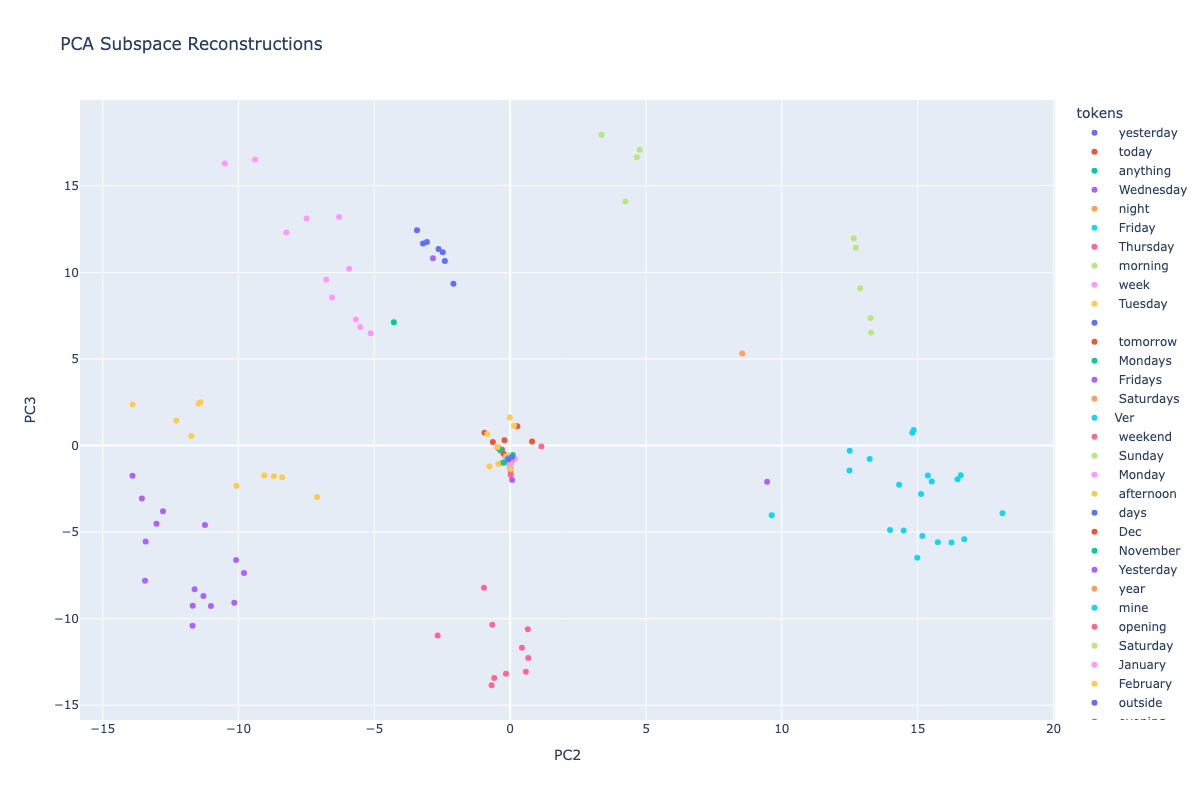

In [22]:
# do PCA on reconstructions
from sklearn.decomposition import PCA
import plotly.express as px 

pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(all_reconstructions.detach().cpu().numpy())

pca_df = pd.DataFrame(pca_embedding, columns=["PC1", "PC2", "PC3"])
pca_df["tokens"] = all_fired_tokens
pca_df["context"] = all_token_dfs.context.values


px.scatter(
    pca_df, x="PC2", y="PC3",
    hover_data=["context"],
    hover_name="tokens",
    height = 800,
    width = 1200,
    color = "tokens",
    title = "PCA Subspace Reconstructions",
).show()

You should be able to see a circular subspace where the order of days of the week is preserved correctly.

### Basics: Intervening on SAE Features

#### Feature Steering

One fun (and sometimes useful) thing we can do once we've found a feature is to use it to steer a model. To do this, we find the maximum activation of a feature in a set of text (using the activation store above), use this as the default scale, multiple it by the vector representing the feature (as extracted from the decoder weights), and finally multiply this by a parameter that we control. This can be varied to see its effect on the text. Below, we'll try steering with a feature that often fires on religious or philosophical statements (feature [20115](https://www.neuronpedia.org/gpt2-small/7-res-jb/20115)). Note that sometimes steering can get GPT2 into a loop, so it's worth running this more than once.

In [23]:
from tqdm import tqdm
from functools import partial 

def find_max_activation(model, sae, activation_store, feature_idx, num_batches=100):
    '''
    Find the maximum activation for a given feature index. This is useful for 
    calibrating the right amount of the feature to add.
    '''
    max_activation = 0.0

    pbar = tqdm(range(num_batches))
    for _ in pbar:
        tokens = activation_store.get_batch_tokens()
        
        _, cache = model.run_with_cache(
            tokens, 
            stop_at_layer=sae.cfg.hook_layer + 1, 
            names_filter=[sae.cfg.hook_name]
        )
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        feature_acts = feature_acts.flatten(0, 1)
        batch_max_activation = feature_acts[:, feature_idx].max().item()
        max_activation = max(max_activation, batch_max_activation)
        
        pbar.set_description(f"Max activation: {max_activation:.4f}")

    return max_activation

def steering(activations, hook, steering_strength=1.0, steering_vector=None, max_act=1.0):
    # Note if the feature fires anyway, we'd be adding to that here.
    return activations + max_act * steering_strength * steering_vector

def generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=1.0, max_new_tokens=95):
    input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)
    
    steering_vector = sae.W_dec[steering_feature].to(model.cfg.device)
    
    steering_hook = partial(
        steering,
        steering_vector=steering_vector,
        steering_strength=steering_strength,
        max_act=max_act
    )
    
    # standard transformerlens syntax for a hook context for generation
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, steering_hook)]):
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos = False if device == "mps" else True,
            prepend_bos = sae.cfg.prepend_bos,
        )
    
    return model.tokenizer.decode(output[0])

# Choose a feature to steer
steering_feature = steering_feature = 20115  # Choose a feature to steer towards

# Find the maximum activation for this feature
max_act = find_max_activation(model, sae, activation_store, steering_feature)
print(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")

# note we could also get the max activation from Neuronpedia (https://www.neuronpedia.org/api-doc#tag/lookup/GET/api/feature/{modelId}/{layer}/{index})

# Generate text without steering for comparison
prompt = "Once upon a time"
normal_text = model.generate(
    prompt,
    max_new_tokens=95, 
    stop_at_eos = False if device == "mps" else True,
    prepend_bos = sae.cfg.prepend_bos,
)

print("\nNormal text (without steering):")
print(normal_text)

# Generate text with steering
steered_text = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=2.0)
print("Steered text:")
print(steered_text)

Max activation: 5.6807: 100%|█████████████████| 100/100 [00:42<00:00,  2.35it/s]


Maximum activation for feature 20115: 5.6807


100%|███████████████████████████████████████████| 95/95 [00:17<00:00,  5.49it/s]



Normal text (without steering):
Once upon a time the whole world and the heavens were full of ruthless criminals. Millions began to see these kinds of thugs as promiscuous young men and widows who ultimately remained happily married to dishonorable two-and-a-half masters of the rainbow.

But now research has revealed that young men like Jean Cathcart are more infatuated with immorally crookish crime writers and serial killers than to court them.

The results of a new study - Areas


100%|███████████████████████████████████████████| 95/95 [00:13<00:00,  7.07it/s]

Steered text:
<|endoftext|>Once upon a time, there was only one civilization.

Today, there are many.

This world is full of nations and nations.

The people are all one.

And yet, there is no one who is not one.

And so, the people have no one to speak for them.

They are all one, and yet, they do not know one another.

And so, the people are all one.

And yet


In [24]:
# Experiment with different steering strengths
print("\nExperimenting with different steering strengths:")
for strength in [-4.0, -2.0, 0.5, 2.0, 4.0]:
    steered_text = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=strength)
    print(f"\nSteering strength {strength}:")
    print(steered_text)


Experimenting with different steering strengths:


100%|███████████████████████████████████████████| 95/95 [00:09<00:00,  9.55it/s]



Steering strength -4.0:
<|endoftext|>Once upon a time, the Piedmont-based company had a huge target market, and in 2010 they announced plans to expand their product line. They initially sold a range of devices, including a Roku TV and the Apple TV, but the launch of the new "HomePod" had a lot of people asking about the device.

"We are really excited about the upcoming HomePod and will be releasing a few more of the new models this fall," said David Stoll, the


100%|███████████████████████████████████████████| 95/95 [00:10<00:00,  9.26it/s]



Steering strength -2.0:
<|endoftext|>Once upon a time, the term "medicinal" was used to describe the treatment of patients with anorexia nervosa. However, the term "medicinal" has been widely used to describe the treatment of a wide range of other conditions. For example, it is commonly used in the treatment of people with depression and other mental health problems.

In this article, we will examine the therapeutic effects of the ketamine ketamine ketamine (KMK) in the


100%|███████████████████████████████████████████| 95/95 [00:10<00:00,  9.47it/s]



Steering strength 0.5:
<|endoftext|>Once upon a time, I was an ambitious student at Hogwarts. But when I arrived at Hogwarts, I was never a good student. I was a really good student. My grades were falling apart, and I was getting a bit of a headache. I was still in high school, but my grades were falling apart, and I was getting a bit of a headache.

But, I wasn't trying to be a bad student. I was just trying to do the best I could for


100%|███████████████████████████████████████████| 95/95 [00:09<00:00,  9.84it/s]



Steering strength 2.0:
<|endoftext|>Once upon a time, my father had a son.

He was of an age when I was in love with him.

He was of a age when I thought of his father.

I told him I was sorry.

He said I had to make him love me again.

I told him I would never again be that boy.

I told him he was nothing.

He told me that I had no chance of ever being a man


100%|███████████████████████████████████████████| 95/95 [00:10<00:00,  9.37it/s]


Steering strength 4.0:
<|endoftext|>Once upon a time, the gods, who were the servants of God, were not with us, and were with us.

But now, behold, the Lord hath come, and hath taken away the one that hath not, and hath not brought forth,

and hath given unto us the knowledge of all things, and of all things,

that is good, and of all things, and of all things,

and of all things, and of all things,


We can also do this via the Neuronpedia AP or on the website [here](https://www.neuronpedia.org/steer/). The example below steers for just a few tokens with a feature that does something very specific. Can you work out what it's doing?

In [25]:
import requests
import numpy as np

url = "https://www.neuronpedia.org/api/steer"

payload = {
    # "prompt": "A knight in shining",
    # "prompt": "He had to fight back in self-", 
    "prompt": "In the middle of the universe is the galactic",
    # "prompt": "Oh no. We're running on empty. Its time to fill up the car with",
    # "prompt": "Sure, I'm happy to pay. I don't have any cash on me but let me write you a",
    "modelId": "gpt2-small",
    "features": [
        {
            "modelId": "gpt2-small",
            "layer": "7-res-jb",
            "index": 6770,
            "strength": 8
        }
    ],
    "temperature": 0.2,
    "n_tokens": 2,
    "freq_penalty": 1,
    "seed": np.random.randint(100),
    "strength_multiplier": 4
}
headers = {"Content-Type": "application/json"}

response = requests.post(url, json=payload, headers=headers)

print(response.json())

{'STEERED': 'In the middle of the universe is the galactic centre of', 'DEFAULT': 'In the middle of the universe is the galactic center.', 'id': 'clyst5owo000frhuo2wsle8mx', 'shareUrl': 'https://www.neuronpedia.org/steer/clyst5owo000frhuo2wsle8mx', 'limit': '59'}


#### Feature Ablation

Feature ablation is also worth looking at. In a way, it's a special case of steering where the value of the feature is always zeroed out.

Here we do the following:
1. Use test prompt rather than generate to get more nuance. 
2. attach a hook to the SAE feature activations.
3. 0 out a feature at all positions (we know that the default feature fires at the final position.)
4. Check whether this ablation is more / less effective if we include the error term (info our SAE isn't capturing).

Note that the existence of [The Hydra Effect](https://arxiv.org/abs/2307.15771) can make reasoning about ablation experiments difficult.

In [26]:
from transformer_lens.utils import test_prompt
from functools import partial

def test_prompt_with_ablation(model, sae, prompt, answer, ablation_features):
    
    def ablate_feature_hook(feature_activations, hook, feature_ids, position = None):
    
        if position is None:
            feature_activations[:,:,feature_ids] = 0
        else:
            feature_activations[:,position,feature_ids] = 0
        
        return feature_activations
        
    ablation_hook = partial(ablate_feature_hook, feature_ids = ablation_features)
    
    model.add_sae(sae)
    hook_point = sae.cfg.hook_name + '.hook_sae_acts_post'
    model.add_hook(hook_point, ablation_hook, "fwd")
    
    test_prompt(prompt, answer, model)
    
    model.reset_hooks()
    model.reset_saes()

# Example usage in a notebook:

# Assume model and sae are already defined

# Choose a feature to ablate

model.reset_hooks(including_permanent=True)
prompt = "In the beginning, God created the heavens and the"
answer = "earth"
test_prompt(prompt, answer, model)


# Generate text with feature ablation
print("Test Prompt with feature ablation and no error term")
ablation_feature = 16873  # Replace with any feature index you're interested in. We use the religion feature
sae.use_error_term = False
test_prompt_with_ablation(model, sae, prompt, answer, ablation_feature)

print("Test Prompt with feature ablation and error term")
ablation_feature = 16873  # Replace with any feature index you're interested in. We use the religion feature
sae.use_error_term = True
test_prompt_with_ablation(model, sae, prompt, answer, ablation_feature)

Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' heavens', ' and', ' the']
Tokenized answer: [' earth']


Performance on answer token:
Rank: 0        Logit: 27.64 Prob: 99.32% Token: | earth|

Top 0th token. Logit: 27.64 Prob: 99.32% Token: | earth|
Top 1th token. Logit: 22.46 Prob:  0.56% Token: | Earth|
Top 2th token. Logit: 19.20 Prob:  0.02% Token: | planets|
Top 3th token. Logit: 18.80 Prob:  0.01% Token: | moon|
Top 4th token. Logit: 18.07 Prob:  0.01% Token: | heavens|
Top 5th token. Logit: 17.67 Prob:  0.00% Token: | oceans|
Top 6th token. Logit: 17.43 Prob:  0.00% Token: | ten|
Top 7th token. Logit: 17.41 Prob:  0.00% Token: | stars|
Top 8th token. Logit: 17.38 Prob:  0.00% Token: | seas|
Top 9th token. Logit: 17.35 Prob:  0.00% Token: | four|


Ranks of the answer tokens: [(' earth', 0)]

Test Prompt with feature ablation and no error term
Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' heavens', ' and', ' the']
Tokenized answer: [' earth']


Performance on answer token:
Rank: 0        Logit: 22.12 Prob: 90.40% Token: | earth|

Top 0th token. Logit: 22.12 Prob: 90.40% Token: | earth|
Top 1th token. Logit: 18.45 Prob:  2.31% Token: | oceans|
Top 2th token. Logit: 18.09 Prob:  1.61% Token: | Earth|
Top 3th token. Logit: 18.06 Prob:  1.55% Token: | seas|
Top 4th token. Logit: 17.65 Prob:  1.03% Token: | planets|
Top 5th token. Logit: 17.43 Prob:  0.83% Token: | moon|
Top 6th token. Logit: 16.28 Prob:  0.26% Token: | moons|
Top 7th token. Logit: 16.12 Prob:  0.22% Token: | sea|
Top 8th token. Logit: 16.10 Prob:  0.22% Token: | stars|
Top 9th token. Logit: 15.56 Prob:  0.13% Token: | Moon|


Ranks of the answer tokens: [(' earth', 0)]

Test Prompt with feature ablation and error term
Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' heavens', ' and', ' the']
Tokenized answer: [' earth']


Performance on answer token:
Rank: 0        Logit: 25.78 Prob: 97.82% Token: | earth|

Top 0th token. Logit: 25.78 Prob: 97.82% Token: | earth|
Top 1th token. Logit: 21.54 Prob:  1.41% Token: | Earth|
Top 2th token. Logit: 19.78 Prob:  0.24% Token: | planets|
Top 3th token. Logit: 19.25 Prob:  0.14% Token: | moon|
Top 4th token. Logit: 17.95 Prob:  0.04% Token: | oceans|
Top 5th token. Logit: 17.71 Prob:  0.03% Token: | stars|
Top 6th token. Logit: 17.35 Prob:  0.02% Token: | other|
Top 7th token. Logit: 17.01 Prob:  0.02% Token: | heavens|
Top 8th token. Logit: 16.88 Prob:  0.01% Token: | seas|
Top 9th token. Logit: 16.74 Prob:  0.01% Token: | four|


Ranks of the answer tokens: [(' earth', 0)]

### Feature Attribution

In [27]:
from dataclasses import dataclass
from functools import partial
from typing import Any, Literal, NamedTuple, Callable

import torch
from sae_lens import SAE
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint


class SaeReconstructionCache(NamedTuple):
    sae_in: torch.Tensor
    feature_acts: torch.Tensor
    sae_out: torch.Tensor
    sae_error: torch.Tensor


def track_grad(tensor: torch.Tensor) -> None:
    """wrapper around requires_grad and retain_grad"""
    tensor.requires_grad_(True)
    tensor.retain_grad()


@dataclass
class ApplySaesAndRunOutput:
    model_output: torch.Tensor
    model_activations: dict[str, torch.Tensor]
    sae_activations: dict[str, SaeReconstructionCache]

    def zero_grad(self) -> None:
        """Helper to zero grad all tensors in this object."""
        self.model_output.grad = None
        for act in self.model_activations.values():
            act.grad = None
        for cache in self.sae_activations.values():
            cache.sae_in.grad = None
            cache.feature_acts.grad = None
            cache.sae_out.grad = None
            cache.sae_error.grad = None


def apply_saes_and_run(
    model: HookedTransformer,
    saes: dict[str, SAE],
    input: Any,
    include_error_term: bool = True,
    track_model_hooks: list[str] | None = None,
    return_type: Literal["logits", "loss"] = "logits",
    track_grads: bool = False,
) -> ApplySaesAndRunOutput:
    """
    Apply the SAEs to the model at the specific hook points, and run the model.
    By default, this will include a SAE error term which guarantees that the SAE
    will not affect model output. This function is designed to work correctly with
    backprop as well, so it can be used for gradient-based feature attribution.

    Args:
        model: the model to run
        saes: the SAEs to apply
        input: the input to the model
        include_error_term: whether to include the SAE error term to ensure the SAE doesn't affect model output. Default True
        track_model_hooks: a list of hook points to record the activations and gradients. Default None
        return_type: this is passed to the model.run_with_hooks function. Default "logits"
        track_grads: whether to track gradients. Default False
    """

    fwd_hooks = []
    bwd_hooks = []

    sae_activations: dict[str, SaeReconstructionCache] = {}
    model_activations: dict[str, torch.Tensor] = {}

    # this hook just track the SAE input, output, features, and error. If `track_grads=True`, it also ensures
    # that requires_grad is set to True and retain_grad is called for intermediate values.
    def reconstruction_hook(sae_in: torch.Tensor, hook: HookPoint, hook_point: str):  # noqa: ARG001
        sae = saes[hook_point]
        feature_acts = sae.encode(sae_in)
        sae_out = sae.decode(feature_acts)
        sae_error = (sae_in - sae_out).detach().clone()
        if track_grads:
            track_grad(sae_error)
            track_grad(sae_out)
            track_grad(feature_acts)
            track_grad(sae_in)
        sae_activations[hook_point] = SaeReconstructionCache(
            sae_in=sae_in,
            feature_acts=feature_acts,
            sae_out=sae_out,
            sae_error=sae_error,
        )

        if include_error_term:
            return sae_out + sae_error
        return sae_out

    def sae_bwd_hook(output_grads: torch.Tensor, hook: HookPoint):  # noqa: ARG001
        # this just passes the output grads to the input, so the SAE gets the same grads despite the error term hackery
        return (output_grads,)

    # this hook just records model activations, and ensures that intermediate activations have gradient tracking turned on if needed
    def tracking_hook(hook_input: torch.Tensor, hook: HookPoint, hook_point: str):  # noqa: ARG001
        model_activations[hook_point] = hook_input
        if track_grads:
            track_grad(hook_input)
        return hook_input

    for hook_point in saes.keys():
        fwd_hooks.append(
            (hook_point, partial(reconstruction_hook, hook_point=hook_point))
        )
        bwd_hooks.append((hook_point, sae_bwd_hook))
    for hook_point in track_model_hooks or []:
        fwd_hooks.append((hook_point, partial(tracking_hook, hook_point=hook_point)))

    # now, just run the model while applying the hooks
    with model.hooks(fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks):
        model_output = model(input, return_type=return_type)

    return ApplySaesAndRunOutput(
        model_output=model_output,
        model_activations=model_activations,
        sae_activations=sae_activations,
    )

In [28]:
from dataclasses import dataclass
from transformer_lens.hook_points import HookPoint
from dataclasses import dataclass
from functools import partial
from typing import Any, Literal, NamedTuple

import torch
from sae_lens import SAE
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint

EPS = 1e-8

torch.set_grad_enabled(True)
@dataclass
class AttributionGrads:
    metric: torch.Tensor
    model_output: torch.Tensor
    model_activations: dict[str, torch.Tensor]
    sae_activations: dict[str, SaeReconstructionCache]


@dataclass
class Attribution:
    model_attributions: dict[str, torch.Tensor]
    model_activations: dict[str, torch.Tensor]
    model_grads: dict[str, torch.Tensor]
    sae_feature_attributions: dict[str, torch.Tensor]
    sae_feature_activations: dict[str, torch.Tensor]
    sae_feature_grads: dict[str, torch.Tensor]
    sae_errors_attribution_proportion: dict[str, float]


def calculate_attribution_grads(
    model: HookedSAETransformer,
    prompt: str,
    metric_fn: Callable[[torch.Tensor], torch.Tensor],
    track_hook_points: list[str] | None = None,
    include_saes: dict[str, SAE] | None = None,
    return_logits: bool = True,
    include_error_term: bool = True,
) -> AttributionGrads:
    """
    Wrapper around apply_saes_and_run that calculates gradients wrt to the metric_fn.
    Tracks grads for both SAE feature and model neurons, and returns them in a structured format.
    """
    output = apply_saes_and_run(
        model,
        saes=include_saes or {},
        input=prompt,
        return_type="logits" if return_logits else "loss",
        track_model_hooks=track_hook_points,
        include_error_term=include_error_term,
        track_grads=True,
    )
    metric = metric_fn(output.model_output)
    output.zero_grad()
    metric.backward()
    return AttributionGrads(
        metric=metric,
        model_output=output.model_output,
        model_activations=output.model_activations,
        sae_activations=output.sae_activations,
    )


def calculate_feature_attribution(
    model: HookedSAETransformer,
    input: Any,
    metric_fn: Callable[[torch.Tensor], torch.Tensor],
    track_hook_points: list[str] | None = None,
    include_saes: dict[str, SAE] | None = None,
    return_logits: bool = True,
    include_error_term: bool = True,
) -> Attribution:
    """
    Calculate feature attribution for SAE features and model neurons following
    the procedure in https://transformer-circuits.pub/2024/march-update/index.html#feature-heads.
    This include the SAE error term by default, so inserting the SAE into the calculation is
    guaranteed to not affect the model output. This can be disabled by setting `include_error_term=False`.

    Args:
        model: The model to calculate feature attribution for.
        input: The input to the model.
        metric_fn: A function that takes the model output and returns a scalar metric.
        track_hook_points: A list of model hook points to track activations for, if desired
        include_saes: A dictionary of SAEs to include in the calculation. The key is the hook point to apply the SAE to.
        return_logits: Whether to return the model logits or loss. This is passed to TLens, so should match whatever the metric_fn expects (probably logits)
        include_error_term: Whether to include the SAE error term in the calculation. This is recommended, as it ensures that the SAE will not affecting the model output.
    """
    # first, calculate gradients wrt to the metric_fn.
    # these will be multiplied with the activation values to get the attributions
    outputs_with_grads = calculate_attribution_grads(
        model,
        input,
        metric_fn,
        track_hook_points,
        include_saes=include_saes,
        return_logits=return_logits,
        include_error_term=include_error_term,
    )
    model_attributions = {}
    model_activations = {}
    model_grads = {}
    sae_feature_attributions = {}
    sae_feature_activations = {}
    sae_feature_grads = {}
    sae_error_proportions = {}
    # this code is long, but all it's doing is multiplying the grads by the activations
    # and recording grads, acts, and attributions in dictionaries to return to the user
    with torch.no_grad():
        for name, act in outputs_with_grads.model_activations.items():
            assert act.grad is not None
            raw_activation = act.detach().clone()
            model_attributions[name] = (act.grad * raw_activation).detach().clone()
            model_activations[name] = raw_activation
            model_grads[name] = act.grad.detach().clone()
        for name, act in outputs_with_grads.sae_activations.items():
            assert act.feature_acts.grad is not None
            assert act.sae_out.grad is not None
            raw_activation = act.feature_acts.detach().clone()
            sae_feature_attributions[name] = (
                (act.feature_acts.grad * raw_activation).detach().clone()
            )
            sae_feature_activations[name] = raw_activation
            sae_feature_grads[name] = act.feature_acts.grad.detach().clone()
            if include_error_term:
                assert act.sae_error.grad is not None
                error_grad_norm = act.sae_error.grad.norm().item()
            else:
                error_grad_norm = 0
            sae_out_norm = act.sae_out.grad.norm().item()
            sae_error_proportions[name] = error_grad_norm / (
                sae_out_norm + error_grad_norm + EPS
            )
        return Attribution(
            model_attributions=model_attributions,
            model_activations=model_activations,
            model_grads=model_grads,
            sae_feature_attributions=sae_feature_attributions,
            sae_feature_activations=sae_feature_activations,
            sae_feature_grads=sae_feature_grads,
            sae_errors_attribution_proportion=sae_error_proportions,
        )
        
        
# prompt = " Tiger Woods plays the sport of"
# pos_token = model.tokenizer.encode(" golf")[0]
prompt = "In the beginning, God created the heavens and the"
pos_token = model.tokenizer.encode(" earth")
neg_token = model.tokenizer.encode(" sky")
def metric_fn(logits: torch.tensor, pos_token: torch.tensor =pos_token, neg_token: torch.Tensor=neg_token) -> torch.Tensor:
    return logits[0,-1,pos_token] - logits[0,-1,neg_token]

feature_attribution_df = calculate_feature_attribution(
    input = prompt,
    model = model,
    metric_fn = metric_fn,
    include_saes={sae.cfg.hook_name: sae},
    include_error_term=True,
    return_logits=True,
)

In [29]:
from transformer_lens.utils import test_prompt
test_prompt(prompt, model.to_string(pos_token), model)

Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' heavens', ' and', ' the']
Tokenized answer: [' earth']


Performance on answer token:
Rank: 0        Logit: 27.64 Prob: 99.32% Token: | earth|

Top 0th token. Logit: 27.64 Prob: 99.32% Token: | earth|
Top 1th token. Logit: 22.46 Prob:  0.56% Token: | Earth|
Top 2th token. Logit: 19.20 Prob:  0.02% Token: | planets|
Top 3th token. Logit: 18.80 Prob:  0.01% Token: | moon|
Top 4th token. Logit: 18.07 Prob:  0.01% Token: | heavens|
Top 5th token. Logit: 17.67 Prob:  0.00% Token: | oceans|
Top 6th token. Logit: 17.43 Prob:  0.00% Token: | ten|
Top 7th token. Logit: 17.41 Prob:  0.00% Token: | stars|
Top 8th token. Logit: 17.38 Prob:  0.00% Token: | seas|
Top 9th token. Logit: 17.35 Prob:  0.00% Token: | four|


Ranks of the answer tokens: [(' earth', 0)]

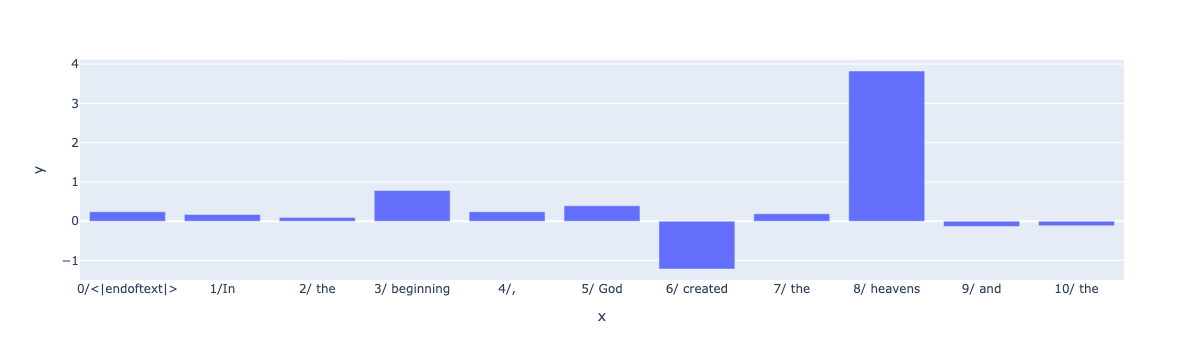

In [30]:
tokens = model.to_str_tokens(prompt)
unique_tokens = [f"{i}/{t}" for i, t in enumerate(tokens)]

px.bar(x = unique_tokens,
       y = feature_attribution_df.sae_feature_attributions[sae.cfg.hook_name][0].sum(-1).detach().cpu().numpy())

In [31]:
def convert_sparse_feature_to_long_df(sparse_tensor: torch.Tensor) -> pd.DataFrame:
    """
    Convert a sparse tensor to a long format pandas DataFrame.
    """
    df = pd.DataFrame(sparse_tensor.detach().cpu().numpy())
    df_long = df.melt(ignore_index=False, var_name='column', value_name='value')
    df_long.columns = ["feature", "attribution"]
    df_long_nonzero = df_long[df_long['attribution'] != 0]
    df_long_nonzero = df_long_nonzero.reset_index().rename(columns={'index': 'position'})
    return df_long_nonzero

df_long_nonzero = convert_sparse_feature_to_long_df(feature_attribution_df.sae_feature_attributions[sae.cfg.hook_name][0])
df_long_nonzero.sort_values("attribution", ascending=False)

position  feature  attribution
522         8    22597     2.092218
45          8     1941     0.839359
383        10    16873     0.657706
201         8    10531     0.602762
194        10    10195     0.570648
..        ...      ...          ...
110         8     5013    -0.348029
234        10    11606    -0.410734
397        10    17519    -0.454038
307        10    14225    -0.473391
444        10    19214    -0.847169

[576 rows x 3 columns]

In [32]:
for i, v in df_long_nonzero.query("position==8").groupby("feature").attribution.sum().sort_values(ascending=False).head(5).items():
    print(f"Feature {i} had a total attribution of {v:.2f}")
    html = get_dashboard_html(sae_release = "gpt2-small", sae_id=f"{sae.cfg.hook_layer}-res-jb", feature_idx=int(i))
    display(IFrame(html, width=1200, height=300))

Feature 22597 had a total attribution of 2.09


Feature 1941 had a total attribution of 0.84


Feature 10531 had a total attribution of 0.60


Feature 1449 had a total attribution of 0.50


Feature 22638 had a total attribution of 0.49


In [33]:
for i, v in df_long_nonzero.groupby("feature").attribution.sum().sort_values(ascending=False).head(5).items():
    print(f"Feature {i} had a total attribution of {v:.2f}")
    html = get_dashboard_html(sae_release = "gpt2-small", sae_id=f"{sae.cfg.hook_layer}-res-jb", feature_idx=int(i))
    display(IFrame(html, width=1200, height=300))

Feature 22597 had a total attribution of 2.09


Feature 16873 had a total attribution of 1.30


Feature 1449 had a total attribution of 1.22


Feature 1941 had a total attribution of 0.84


Feature 10195 had a total attribution of 0.62
